In [1]:
# This section installs packages needed to run the script. 

import folium
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import openeo
from shapely.geometry import shape, Point
from rasterio import warp
from matplotlib import cm
from matplotlib.colors import Normalize
import folium.raster_layers
import rasterio
from rasterio import warp
import numpy as np


In [2]:
#This establishes a connection with the Sentenel satelite data. 

connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

#if this does not read as 'Authorised successfully' or 'Authenticated using refresh token', then please ensure that you have completed the setup steps as outlined in section 2.6 of the user guide. 
#if you have followed the steps in section 2.6 correctly and the problem persists, please look at https://dataspace.copernicus.eu/news for any information about service interruptions. 
#if there is no news of service problems you can raise a ticket here: https://helpcenter.dataspace.copernicus.eu/hc/en-gb/requests/new

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [4]:
# This downloads the gas concentration data for a particular date

cube = connection.load_collection(
    collection_id="SENTINEL_5P_L2", 
    temporal_extent=["2023-02-24", "2023-02-24"], # Select a date range using the format YYYY-MM-DD
    spatial_extent={"west": -19.5, "south": 27.0, "east": 5.0, "north": 44.5}, # these coordinates define the area to be downloaded (Peninsular Spain, the Canaries and Baleric islands along with some of North Africa)
    bands=["CH4"], # The options for gas monitoring are: 'CO', 'HCHO', 'NO2', 'O3', 'SO2', 'CH4'
)

cube.download("Sentinel-5P_Spain.GTiff")

In [5]:
# Currently the data is projected in EPSG:4326 and to display correctly on the map it needs to be EPSG:3857. This script does that. 

# The destination coordinate reference system (CRS)
dst_crs = 'EPSG:3857'

# Open the gas data file that is in ESPG:4326 and calculate its bounds
with rasterio.open('Sentinel-5P_Spain.GTiff') as src:
    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # Copy and update the metadata from the source dataset
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Create a new gas data file in EPSG:3857 
    with rasterio.open('Sentinel-5P_Spain3857.GTiff', 'w', **kwargs) as dst: #if you wish to run this without restarting the kernel, you will need to rename this
        # Loop through each band in the source dataset
        for ind in range(1, src.count + 1):
            # Reproject each band and write it to the destination dataset
            rasterio.warp.reproject(
                source=rasterio.band(src, ind),
                destination=rasterio.band(dst, ind),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=rasterio.warp.Resampling.nearest)
            
            


C:\Users\kinse\AppData\Local\Temp\ipykernel_15508\1281247690.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = PZ_landfill_Locations.geometry.centroid



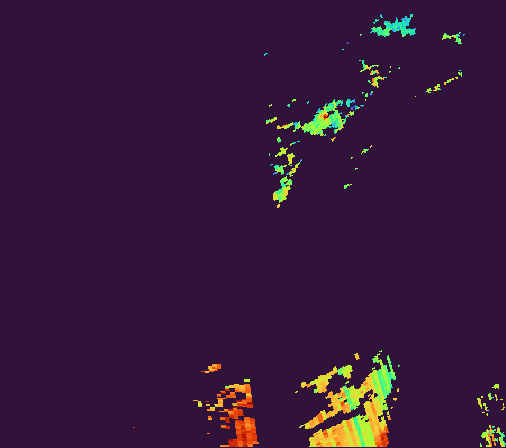

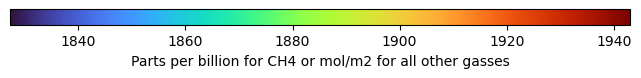

In [6]:
# This section loads the map 

#This is the reprojected gas data
gas_data = r'C:\GIS_Course\EGM722\Project\Sentinel-5P_Spain3857.GTiff'

# Open raster file, load values and prepare them to be displayed.
dataset = rasterio.open(gas_data, 'r')  
rasdata = dataset.read()[0]  
rasdata_normed = rasdata / rasdata.max() * 10  

# set bounds using EPSG:3857 projection
dest_crs = 'EPSG:3857'
left, bottom, right, top = [i for i in dataset.bounds]
bounds_4326 = warp.transform_bounds(src_crs=dataset.crs, dst_crs=dest_crs, left=left,
                                    bottom=bottom, right=right, top=top)

# Loading colourmap for gas_data
colormap = cm.turbo  

# When the data is displayed, this says to ignore values of zero. 
non_zero_values = rasdata[rasdata != 0]
min_value = non_zero_values.min()
max_value = non_zero_values.max()
normalized_data = (non_zero_values - min_value) / (max_value - min_value)

# Create a colormap for the non-zero values
colormap_index = np.zeros_like(rasdata, dtype=np.float64)
colormap_index[rasdata != 0] = normalized_data

#Loading in the landfill locations
PZ_landfill_Locations = gpd.read_file(r"C:\GIS_Course\EGM722\Project\Data\PZ_landfill_point4326.geojson")
Test_landfill_Location = gpd.read_file(r"C:\GIS_Course\EGM722\Project\Data\test_landfill.geojson")

# This creates the map and centres it on the geometries.
centroids = PZ_landfill_Locations.geometry.centroid
center = [centroids.y.mean(), centroids.x.mean()]
gas_concentration_map = folium.Map(location=center, zoom_start=5, tiles='CartoDB Positron')

# Adding the PreZero landfill locations to the map and making them clickable for info
for feature in PZ_landfill_Locations.iterfeatures():
    # Extract feature number from properties
    feature_number = feature['properties']['Landfill'] 
    # Extract coordinates of the feature
    coordinates = feature['geometry']['coordinates']
    # Create a marker with label for each feature
    folium.Marker(location=[coordinates[1], coordinates[0]], 
                  popup=f"Feature {feature_number}").add_to(gas_concentration_map)

# Adding the Test landfill location to the map and making it clickable for info
for feature in Test_landfill_Location.iterfeatures():
    # Extract feature number from properties
    feature_number = feature['properties']['DIRECCION'] 
    # Extract coordinates of the feature
    coordinates = feature['geometry']['coordinates']
    # Create a marker with label for each feature
    folium.Marker(location=[coordinates[1], coordinates[0]], 
                  popup=f"Feature {feature_number}").add_to(gas_concentration_map)

# Adding the gas concentration dataset to the map
folium.raster_layers.ImageOverlay(
    image=colormap(colormap_index),
    name='gas concentration in atmosphere',
    opacity=0.6,
    bounds=[[27.0, -19.5], [44.4, 5.0]],  # this should be the same as the spatial extent of cube
    interactive=False,
    cross_origin=False,
    zindex=1
).add_to(gas_concentration_map)

# Creating the legend for gas concentration
fig, ax = plt.subplots(figsize=(8, 0.2))
cbar = plt.colorbar(cm.ScalarMappable(norm=Normalize(vmin=min_value, vmax=max_value),
                                      cmap=colormap),
                    cax=ax, orientation='horizontal')
cbar.set_label('Parts per billion for CH4 or mol/m2 for all other gasses')

# Display the map
gas_concentration_map

#CH4 measurements are column averaged dry air mixing ratio of methane (parts per billion). Ranges of 1,600 - 2,000
#NO2 measurements are Nitrogen dioxide tropospheric column (mol/m2). Ranges of 0 - 0.0003
#CO measurements are Carbon monoxide total column (mol/m2). Ranges of 0 - 0.1
#HCHO measurements are Formaldehyde troposheric vertical column (mol/m2). Ranges of 0 - 0.001
#O3 measurements are Ozone total column (mol/m2). Ranges of 0 - 0.36
#SO2 measurements are Sulfur dioxide total column (mol/m2). Ranges of 0 - 0.01
#More information: https://docs.sentinel-hub.com/api/latest/data/sentinel-5p-l2/

# the warning "...Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect..." can be ignored. 